In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

sns.set(style="whitegrid")

In [ ]:
df = pd.read_csv("KiK-Net_cleaned.csv")
df.drop(columns=['s_no', 'Code', 'Adress'], inplace=True)
df.replace('-', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

drop_cols = ['stationLat', 'stationLon', 'latitude', 'longitude', 'r(epicenter)', 'r(hypocentral)', 'ztor', 'ia(area_intensity)']
df.drop(columns=drop_cols, inplace=True)

thresh = df['pga(g)'].quantile(0.90)
df_high = df[df['pga(g)'] > thresh]
df_low = df[df['pga(g)'] <= thresh]

upsample_ratio = 0.05
n_target = int(len(df_low) * upsample_ratio)
df_high_upsampled = resample(df_high, replace=True, n_samples=n_target, random_state=42)
# Combine and shuffle
df_balanced = pd.concat([df_low, df_high_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# df_balanced = df.copy()

X = df_balanced.drop(columns=['pga(g)'])
y = df_balanced['pga(g)']
y_log = np.log1p(y)

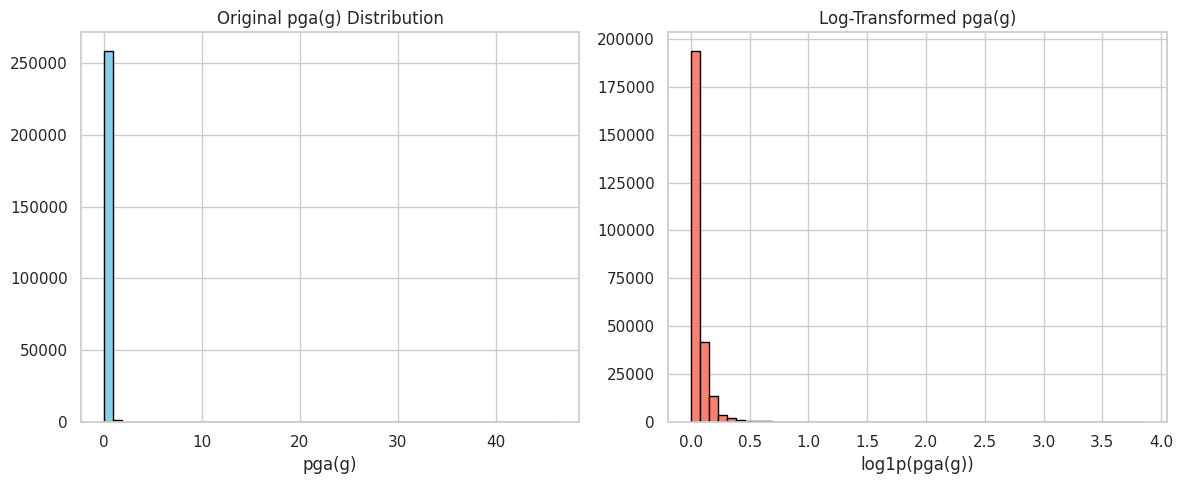

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y, bins=50, color='skyblue', edgecolor='black')
plt.title("Original pga(g) Distribution")
plt.xlabel("pga(g)")

plt.subplot(1, 2, 2)
plt.hist(y_log, bins=50, color='salmon', edgecolor='black')
plt.title("Log-Transformed pga(g)")
plt.xlabel("log1p(pga(g))")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold

# Assume X and y are already defined and unscaled

# Initialize K-Fold
kf = KFold(n_splits=3, shuffle=True, random_state=42)
train_idx, test_idx = next(kf.split(X))

# Create train/test splits
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]

# Define a function to compute and print statistics
def compute_statistics(df, name="Dataset"):
    stats = pd.DataFrame({
        "Mean": df.mean(),
        "Std Dev": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Median": df.median()
        # "Missing (%)": df.isna().mean() * 100
    })
    print(f"\n--- {name} Statistics ---")
    print(stats.round(3))

# Compute and print stats
compute_statistics(X, "Entire Dataset")
compute_statistics(X_train, "Training Set")
compute_statistics(X_test, "Testing Set")


--- Entire Dataset Statistics ---
                            Mean  Std Dev      Min       Max   Median
magnitude                  4.902    0.935    3.000     9.000    4.700
Vs30                     469.658  218.358  111.114  2100.000  428.101
depth(Km)                 49.903   58.738    0.000   619.000   44.000
Tectonic_Garcia_           2.125    1.014    1.000     5.000    2.000
Focal_mechanism_Garcia_    1.163    0.966    0.000     3.000    1.000
r(rupture)               197.259  170.487    3.118  1927.177  149.017

--- Training Set Statistics ---
                            Mean  Std Dev      Min       Max   Median
magnitude                  4.900    0.934    3.000     9.000    4.700
Vs30                     469.691  218.217  111.114  2100.000  428.101
depth(Km)                 50.010   58.879    0.000   619.000   44.000
Tectonic_Garcia_           2.125    1.012    1.000     5.000    2.000
Focal_mechanism_Garcia_    1.162    0.965    0.000     3.000    1.000
r(rupture)            

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Set up 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
train_indices, test_indices = next(kf.split(X_scaled))

# Split the data into training and testing sets
X_train = X_scaled.iloc[train_indices]
X_test = X_scaled.iloc[test_indices]

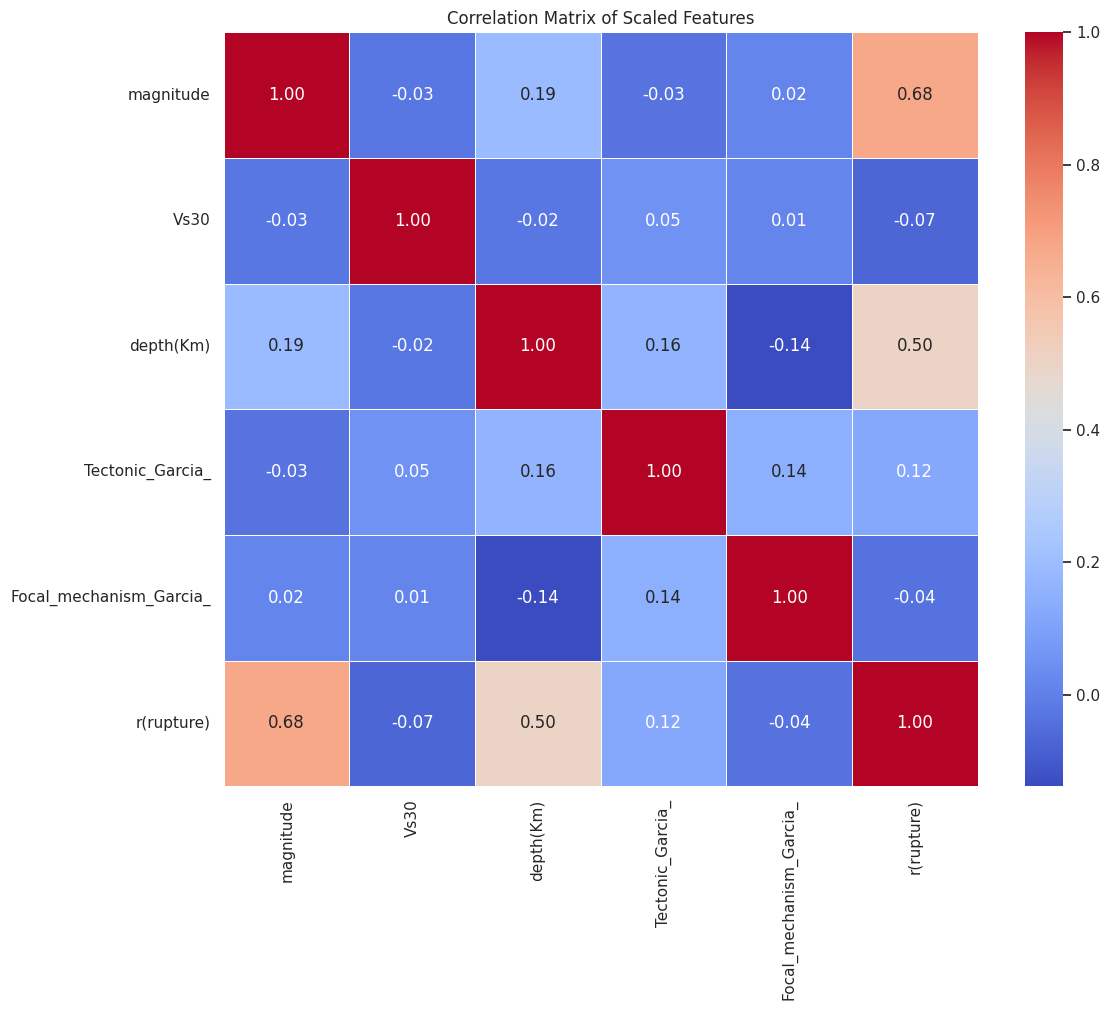

In [ ]:
corr_matrix_scaled = X_scaled.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix_scaled,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix of Scaled Features")
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dropout(0.1),

        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse',  # Could replace with custom loss
        metrics=['mae']
    )
    return model



===== Fold 1 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.3901 - mae: 0.4183 - val_loss: 0.0154 - val_mae: 0.0643
Epoch 2/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0392 - mae: 0.1375 - val_loss: 0.0117 - val_mae: 0.0518
Epoch 3/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0194 - mae: 0.0854 - val_loss: 0.0098 - val_mae: 0.0469
Epoch 4/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - mae: 0.0649 - val_loss: 0.0090 - val_mae: 0.0435
Epoch 5/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - mae: 0.0552 - val_loss: 0.0082 - val_mae: 0.0437
Epoch 6/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - mae: 0.0512 - val_loss: 0.0075 - val_mae: 0.0415
Epoch 7/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - mae: 0.0488 - val_loss: 0.0078 - val_mae: 0.0406
Epoch 8/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - mae: 0.0468 - val_loss: 0.0071 - val_mae: 0.0412
Epoch 9/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

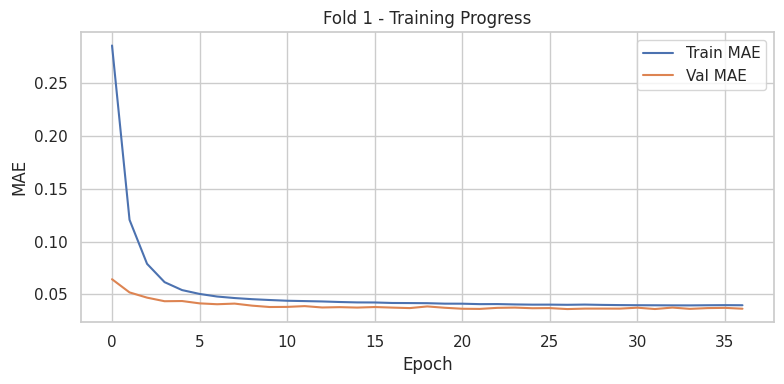


===== Fold 2 =====
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.3403 - mae: 0.3855 - val_loss: 0.0159 - val_mae: 0.0607
Epoch 2/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0346 - mae: 0.1269 - val_loss: 0.0118 - val_mae: 0.0487
Epoch 3/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - mae: 0.0805 - val_loss: 0.0098 - val_mae: 0.0448
Epoch 4/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - mae: 0.0624 - val_loss: 0.0088 - val_mae: 0.0432
Epoch 5/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - mae: 0.0533 - val_loss: 0.0078 - val_mae: 0.0409
Epoch 6/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - mae: 0.0496 - val_loss: 0.0075 - val_mae: 0.0399
Epoch 7/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - mae: 0.0471 - val_loss: 0.0070 - val_mae: 0.0401
Epoch 8/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - mae: 0.0462 - val_loss: 0.0069 - val_mae: 0.0388
Epoch 9/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

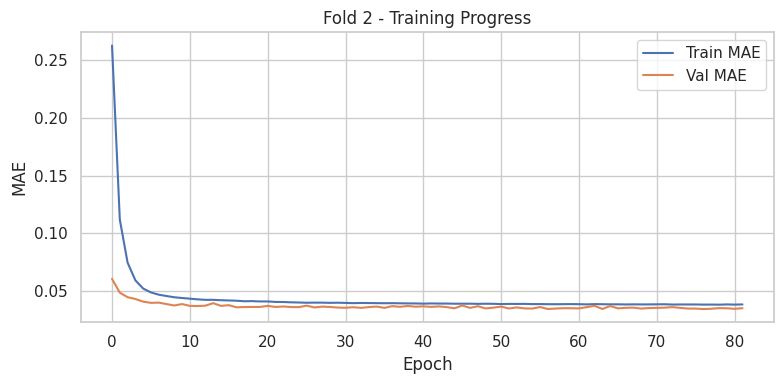


===== Fold 3 =====
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.3294 - mae: 0.3847 - val_loss: 0.0162 - val_mae: 0.0684
Epoch 2/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0369 - mae: 0.1328 - val_loss: 0.0108 - val_mae: 0.0516
Epoch 3/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - mae: 0.0850 - val_loss: 0.0092 - val_mae: 0.0452
Epoch 4/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - mae: 0.0649 - val_loss: 0.0083 - val_mae: 0.0437
Epoch 5/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - mae: 0.0552 - val_loss: 0.0076 - val_mae: 0.0426
Epoch 6/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - mae: 0.0509 - val_loss: 0.0073 - val_mae: 0.0405
Epoch 7/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - mae: 0.0481 - val_loss: 0.0073 - val_mae: 0.0407
Epoch 8/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0086 - mae: 0.0467 - val_loss: 0.0077 - val_mae: 0.0398
Epoch 9/100
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

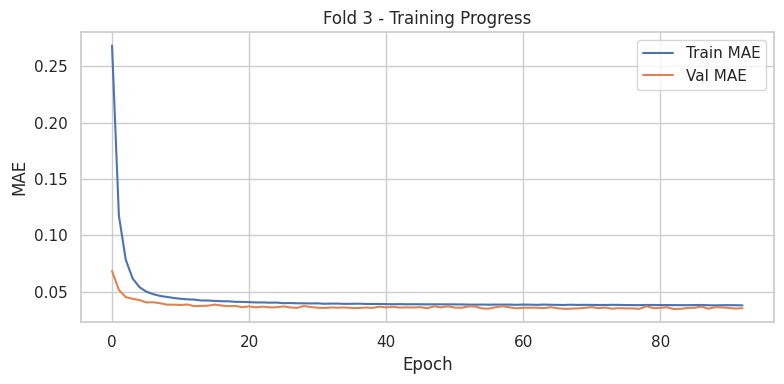


=== Cross-Validation Summary ===
Train Metrics:
R²:   0.5735 ± 0.0485
MAE:  0.0474 ± 0.0011
RMSE: 0.2307 ± 0.0160

Test Metrics:
R²:   0.5444 ± 0.0337
MAE:  0.0479 ± 0.0003
RMSE: 0.2386 ± 0.0154


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Log-transform the target
y_log = np.log1p(y)

# === Step 2: Prepare K-Fold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# === Step 3: Metric storage
train_r2_scores, train_mae_scores, train_rmse_scores = [], [], []
test_r2_scores, test_mae_scores, test_rmse_scores = [], [], []

# === Step 4: For collecting predictions across folds
all_y_true = []
all_y_pred = []

fold = 1

for train_idx, test_idx in kf.split(X):
    print(f"\n===== Fold {fold} =====")

    # Split
    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train_log, y_test_log = y_log.iloc[train_idx], y_log.iloc[test_idx]

    # Scale
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=X.columns)

    # Build model
    model = build_model(X_train.shape[1])

    # Train model
    history = model.fit(
        X_train, y_train_log,
        validation_split=0.2,
        epochs=100,
        batch_size=512,
        verbose=1,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )

    # Predict and inverse log
    y_train_pred_log = model.predict(X_train).flatten()
    y_test_pred_log = model.predict(X_test).flatten()
    y_train_true = np.expm1(y_train_log)
    y_test_true = np.expm1(y_test_log)
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred = np.expm1(y_test_pred_log)

    # Append predictions from test folds
    all_y_true.extend(y_test_true)
    all_y_pred.extend(y_test_pred)

    # Train metrics
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))

    # Test metrics
    test_r2 = r2_score(y_test_true, y_test_pred)
    test_mae = mean_absolute_error(y_test_true, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

    # Store
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_rmse_scores.append(train_rmse)

    test_r2_scores.append(test_r2)
    test_mae_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)

    # Print fold results
    print(f"Fold {fold} Metrics:")
    print(f"Train → R²: {train_r2:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Test  → R²: {test_r2:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")

    # Plot training curve
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f"Fold {fold} - Training Progress")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fold += 1

# === Final Summary
print("\n=== Cross-Validation Summary ===")
print("Train Metrics:")
print(f"R²:   {np.mean(train_r2_scores):.4f} ± {np.std(train_r2_scores):.4f}")
print(f"MAE:  {np.mean(train_mae_scores):.4f} ± {np.std(train_mae_scores):.4f}")
print(f"RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}")

print("\nTest Metrics:")
print(f"R²:   {np.mean(test_r2_scores):.4f} ± {np.std(test_r2_scores):.4f}")
print(f"MAE:  {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"RMSE: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")




In [ ]:
# Convert lists to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# === Overall Metrics Across All Folds ===
overall_r2 = r2_score(all_y_true, all_y_pred)
overall_mae = mean_absolute_error(all_y_true, all_y_pred)
overall_rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))

print("\n=== Overall Metrics (All Folds Combined) ===")
print(f"R²:   {overall_r2:.4f}")
print(f"MAE:  {overall_mae:.4f}")
print(f"RMSE: {overall_rmse:.4f}")



=== Overall Metrics (All Folds Combined) ===
R²:   0.5426
MAE:  0.0479
RMSE: 0.2391


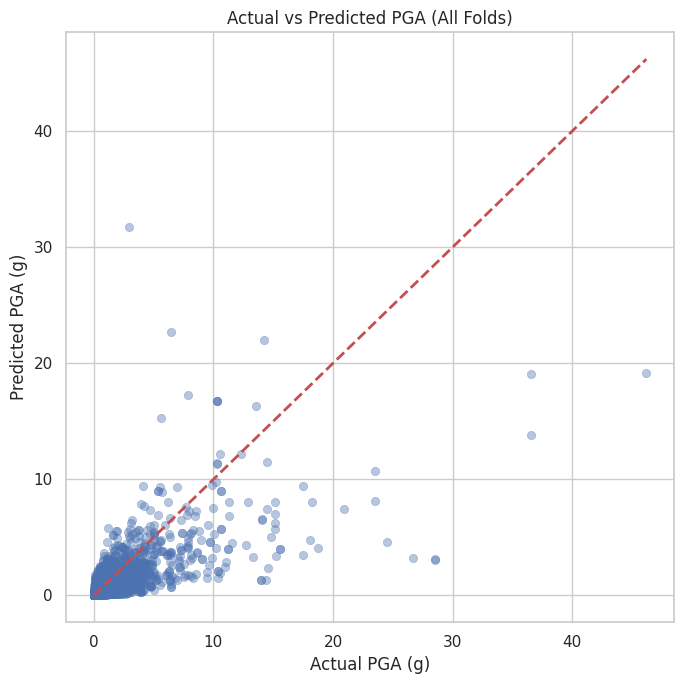

In [ ]:
# === Actual vs Predicted Plot
def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted PGA (All Folds)"):
    plt.figure(figsize=(7, 7))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.4, edgecolor=None)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel("Actual PGA (g)")
    plt.ylabel("Predicted PGA (g)")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(np.array(all_y_true), np.array(all_y_pred))

In [ ]:
def plot_residuals(y_true, y_pred, title="Residual Plot (All Folds)"):
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.4, edgecolor=None)
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("Predicted PGA (g)")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

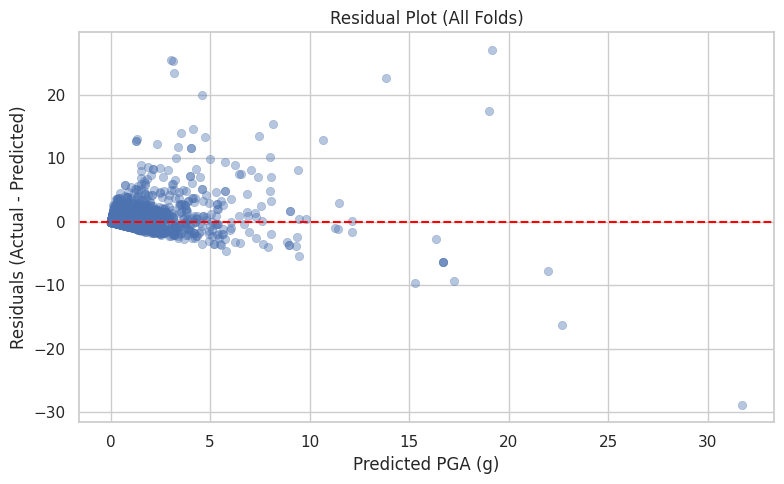

In [ ]:
plot_residuals(np.array(all_y_true), np.array(all_y_pred))

In [ ]:
from scipy.stats import skew, kurtosis

def plot_residual_distribution(y_true, y_pred, title="Residual Distribution (All Folds)"):
    residuals = y_true - y_pred

    # === Plot residual distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=100, kde=True, color='skyblue', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Print residual statistics
    print("\n--- Residual Statistics ---")
    print(f"Mean       : {np.mean(residuals):.4f}")
    print(f"Std Dev    : {np.std(residuals):.4f}")
    print(f"Skewness   : {skew(residuals):.4f}")
    print(f"Kurtosis   : {kurtosis(residuals):.4f}")  # excess kurtosis (0 for normal dist)

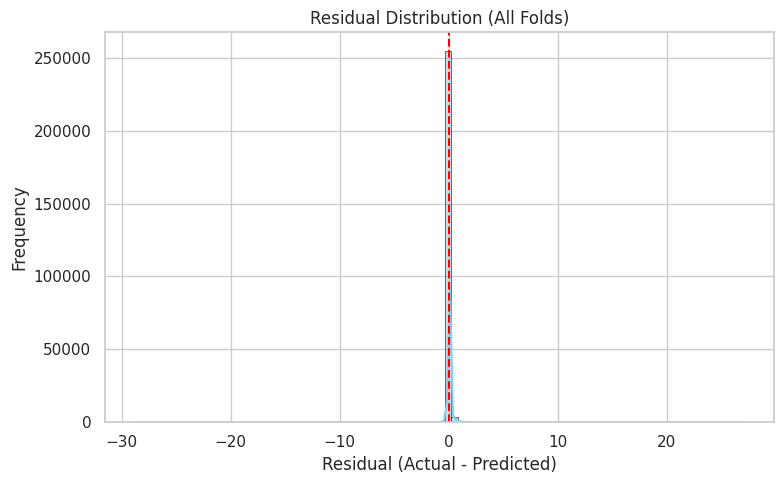


--- Residual Statistics ---
Mean       : 0.0098
Std Dev    : 0.2389
Skewness   : 31.7650
Kurtosis   : 4161.0838


In [ ]:
plot_residual_distribution(np.array(all_y_true), np.array(all_y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define custom PGA bins (you can customize this)
pga_bins = [0.0, 0.1, 1.0, float('inf')]
pga_labels = ["Low", "Moderate", "High"]

# Bin the PGA values into classes
def bin_pga(values, bins=pga_bins, labels=pga_labels):
    return pd.cut(values, bins=bins, labels=labels, right=False, include_lowest=True)

In [ ]:
# Convert lists to arrays (if not already)
y_true_array = np.array(all_y_true, dtype=float)
y_pred_array = np.array(all_y_pred, dtype=float)


# Bin both actual and predicted values
y_true_class = bin_pga(y_true_array)
y_pred_class = bin_pga(y_pred_array)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_clean_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix: Binned PGA Classes"):
    # Compute confusion matrix
    cm = confusion_matrix(y_true_class.astype(str), y_pred_class.astype(str), labels=[str(label) for label in pga_labels])

    # Create DataFrame for better formatting
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5, linecolor='gray',
                annot_kws={"size": 10})

    plt.title(title, fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

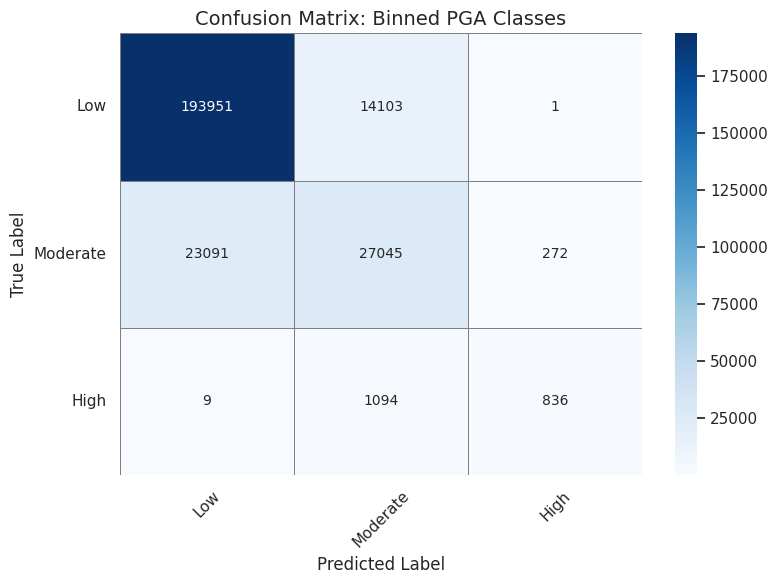

In [ ]:
plot_clean_confusion_matrix(y_true_class, y_pred_class, labels=pga_labels)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

In [ ]:
# Accuracy, Precision, Recall, and F1-score
print("\n=== Classification Report ===")
print(classification_report(y_true_class.astype(str), y_pred_class.astype(str), labels=pga_labels, zero_division=0))

acc = accuracy_score(y_true_class.astype(str), y_pred_class.astype(str))
print(f"\nOverall Accuracy: {acc:.4f}")


=== Classification Report ===
              precision    recall  f1-score   support

         Low       0.89      0.93      0.91    208056
    Moderate       0.64      0.54      0.58     50408
        High       0.75      0.43      0.55      1939

   micro avg       0.85      0.85      0.85    260403
   macro avg       0.76      0.63      0.68    260403
weighted avg       0.84      0.85      0.85    260403


Overall Accuracy: 0.8519


/tmp/ipython-input-1-1256975690.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='Total_Rank', palette='viridis', edgecolor='black')


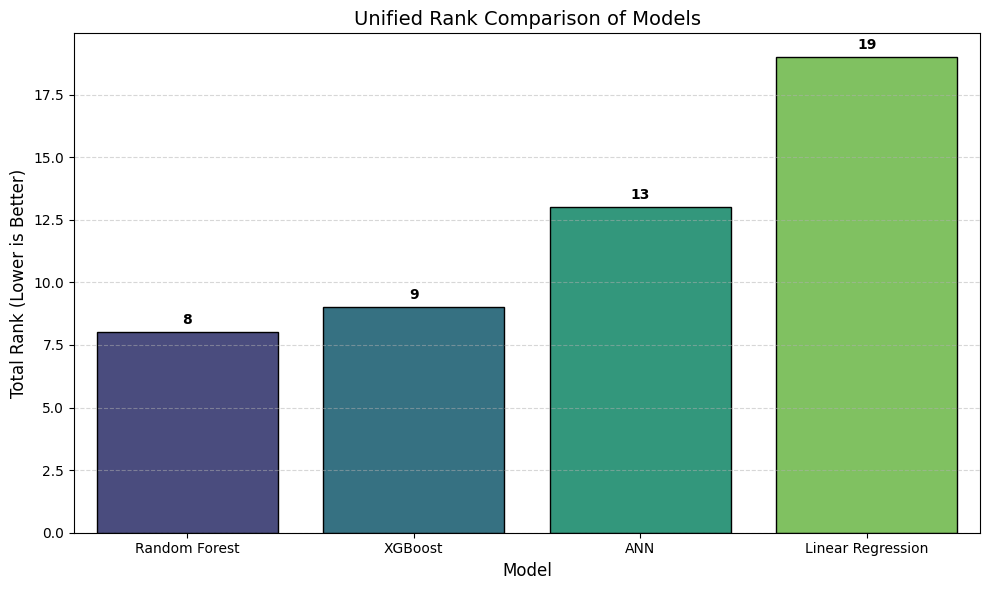

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 1: Define your model performance metrics ===
# Replace with your actual evaluation results
metrics_df = pd.DataFrame({
    'Model': ['ANN', 'XGBoost', 'Random Forest', 'Linear Regression'],
    'R2': [0.587, 0.721, 0.923, 0.487],
    'RMSE': [0.227, 0.186, 0.034, 0.266],
    'MAE': [0.047, 0.045, 0.019, 0.057],
    'Accuracy': [0.849, 0.855, 0.870, 0.801],
    'F1': [0.85, 0.85, 0.73, 0.74]
})

# === STEP 2: Compute ranks per metric ===
higher_better = ['R2', 'Accuracy', 'F1']
lower_better = ['RMSE', 'MAE']

# Rank higher-is-better metrics (descending)
for col in higher_better:
    metrics_df[col + '_rank'] = metrics_df[col].rank(ascending=False, method='min')

# Rank lower-is-better metrics (ascending)
for col in lower_better:
    metrics_df[col + '_rank'] = metrics_df[col].rank(ascending=True, method='min')

# === STEP 3: Compute total unified rank ===
rank_cols = [col for col in metrics_df.columns if col.endswith('_rank')]
metrics_df['Total_Rank'] = metrics_df[rank_cols].sum(axis=1)
metrics_df.sort_values('Total_Rank', inplace=True)

# === STEP 4: Plot Unified Rank Bar Chart ===
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='Total_Rank', palette='viridis', edgecolor='black')

# Add values on top
for i, val in enumerate(metrics_df['Total_Rank']):
    plt.text(i, val + 0.2, f"{val:.0f}", ha='center', va='bottom', fontweight='bold')

plt.title('Unified Rank Comparison of Models', fontsize=14)
plt.ylabel('Total Rank (Lower is Better)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
!pip install skill_metrics

ERROR: Could not find a version that satisfies the requirement skill_metrics (from versions: none)
ERROR: No matching distribution found for skill_metrics


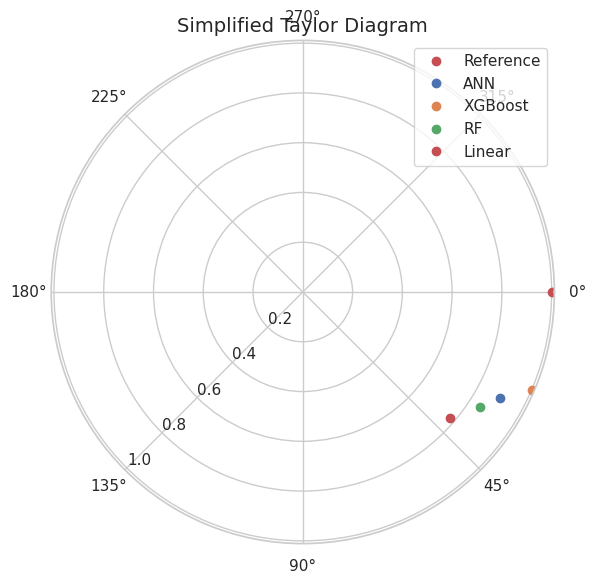

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example stats (std_dev, correlation) for 3 models
models = {
    'ANN': (0.9, 0.88),
    'XGBoost': (1.0, 0.92),
    'RF': (0.85, 0.84),
    'Linear': (0.78, 0.76)
}

ref_std = 1.0  # Standard deviation of observed values

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)

# Set up correlation grid (theta)
corrs = np.linspace(0, 1, 100)
theta = np.arccos(corrs)

# Set up radial axis = standard deviation
ax.set_theta_zero_location('E')
ax.set_theta_direction(-1)
ax.set_rlabel_position(135)

# Plot reference point
ax.plot([0], [ref_std], 'ro', label='Reference')

# Plot models
for name, (std_dev, corr) in models.items():
    angle = np.arccos(corr)
    ax.plot(angle, std_dev, 'o', label=name)

# Add grid and legend
ax.set_title("Simplified Taylor Diagram", fontsize=14)
ax.grid(True)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()
